# A simple digital twin

The goal of this notebook is to build a basic digital twin system, showcasing the classes and design choices of the core components of the library.

A digital twin is implemented through the definition of:  
- a physical simulation, whose state evolves according to some (possibly black-box) rules and can be queried for observations (of the state itself, or related quantities)
- a discretized description of the simulation's state, with an inverse problem procedure that converts observations of the physical model into a digital state value
- a list of actions, which encode a model of the evolution of the discretized state, and which are fed to the physical model to trigger updates
- a policy that selects an action based on the available discretized state

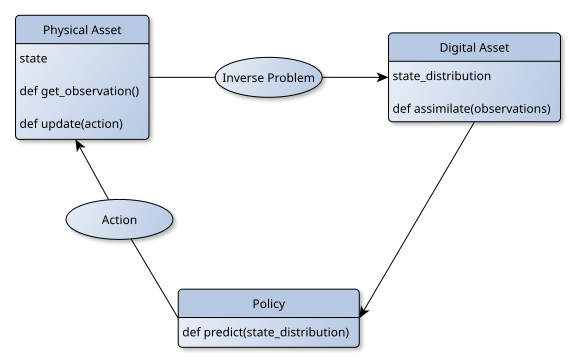

In this notebook, we will assemble these components starting from the [CartPole-v1](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment from gymnasium.  

To obtain a digital twin system that leverages our library, we will follow this schema:

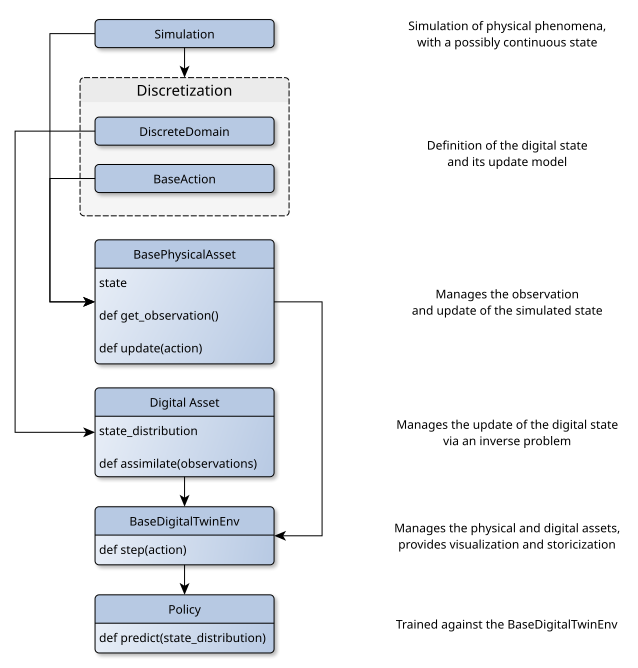


In [1]:
import numpy as np
import pandas as pd

import gymnasium as gym
from gymnasium import spaces

env = gym.make("CartPole-v1", render_mode="rgb_array")

state_space_labels = [
    "Cart Position",
    "Cart Velocity",
    "Pole Angle",
    "Pole Angular Velocity",
]
state_space: spaces.Box = env.observation_space
state_space_bounds = np.array([state_space.low, state_space.high]).T
state_space_df = pd.DataFrame(
    state_space_bounds, columns=["Low", "High"], index=state_space_labels
)

state_space_df

,Low,High
Cart Position,-4.800000,4.800000
Cart Velocity,-inf,inf
Pole Angle,-0.418879,0.418879
Pole Angular Velocity,-inf,inf


The environment has an internal state with 4 dimensions.  
However, the actual possible values for the Cart Position and Pole Angle are limited to (-2.4, 2.4) and (-.2095, .2095), respectively. The environment is terminated when these bounds are exceeded.
  
We need to discretize the state space and, in case a Probabilistic Graphical Model is employed, the state transitions due to the Actions.  

To discretize the state space, we build a DiscreteDomain where:
- Cart Position is discretized with 9 ticks in the feasible interval
- Cart Velocity takes values in [-1, 0, 1]
- Pole Angle is discretized with 9 ticks in the feasible interval
- Pole Angular Velocity takes values in [-1, 0, 1]

The environment terminates when these bounds are exceeded.  


In [2]:
from pgmtwin.core.domain import DiscreteDomain


state_domain = DiscreteDomain(
    var2values={
        "Cart Position": np.linspace(*(state_space_bounds[0] / 2), 9),
        "Cart Velocity": np.linspace(-1, 1, 3),
        "Pole Angle": np.linspace(*(state_space_bounds[2] / 2), 9),
        "Pole Angular Velocity": np.linspace(-1, 1, 3),
    }
)

n_states = len(state_domain)
print(f"n_states {n_states}")

with np.printoptions(precision=3):
    print(repr(state_domain))

n_states 729
DiscreteDomain['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity'] len 729 value shape (4,)
    Cart Position [-2.4 -1.8 -1.2 -0.6  0.   0.6  1.2  1.8  2.4]
    Cart Velocity [-1.  0.  1.]
    Pole Angle [-0.209 -0.157 -0.105 -0.052  0.     0.052  0.105  0.157  0.209]
    Pole Angular Velocity [-1.  0.  1.]


The environment supports two discrete Actions:
- 0 Push cart to the left
- 1 Push cart to the right

No control on the force is available, nor equations to predict the effect on the physical or digital state: to bypass this issue, one could construct the transitions empirically.  

Since this simple example does not employ a Probabilistic Graphical Model, the discretized dynamics are not required and the BaseAction class will be used.  

In [3]:
from pgmtwin.core.action import BaseAction

actions = [
    BaseAction("left", state_domain),
    BaseAction("right", state_domain),
]

With the Action objects defined, we can wrap the CartPole environment in a PhysicalAsset class.  

The internal state mirrors the environment's, and the observations are a simple forward of the internal state.  
Moreover, the physical asset implementation also tracks the terminated state.  


In [4]:
import numpy as np
from pgmtwin.core.action import BaseAction
from pgmtwin.core.physical_asset import BasePhysicalAsset


class CartPolePhysicalAsset(BasePhysicalAsset):
    def __init__(
        self,
        rng: np.random.Generator = None,
    ):
        if rng is None:
            rng = np.random.default_rng()

        self.env = gym.make(
            "CartPole-v1",
            render_mode="rgb_array",
        )
        obs, _ = self.env.reset(seed=int(rng.integers(2**32)))

        self.state = obs
        self.terminated = False

        super().__init__(self.state, rng)

    def set_state(self, state: np.ndarray):
        self.env.reset()
        self.env.unwrapped.state = state
        self.terminated = False

    def update(self, action: BaseAction):
        a = 0 if action.name == "left" else 1
        obs, _, terminated, _, _ = self.env.step(a)

        self.state = obs
        self.terminated = terminated

    def get_observations(self, n_observations: int = 1) -> np.ndarray:
        return self.state.reshape(1, -1)

A digital asset needs to hold the probability distribution of the discretized state and implement an inverse problem for the assimilation of observations from the physical asset.  
  
For this simple case, the inverse problem is trivial since the observations coincide with the physical state. The actual implementation consists of the discretization, through the digital state domain, of the observation records.  


In [5]:
from pgmtwin.core.digital_asset import BaseDigitalAsset


class CartPoleDigitalAsset(BaseDigitalAsset):
    def __init__(
        self,
        rng: np.random.Generator = None,
    ):
        super().__init__(state_domain, rng)

    def get_assimilation(self, observations: np.ndarray) -> np.ndarray:
        return self.state_domain.values2values(observations)

    def get_assimilation_distribution(self, observations: np.ndarray) -> np.ndarray:
        ret = np.zeros(len(self.state_domain))
        for obs in observations:
            state_idx = self.state_domain.values2index(obs)
            ret[state_idx] += 1
        return ret / np.sum(ret)

    def get_qois(self) -> np.ndarray:
        return np.empty(0)

At this point, we need to train a policy which, observing the digital state as a probability distribution, selects the action to trigger.  

This policy needs to be trained within the digital state and update model.
To do so, a reward is needed: we define a function that takes the physical state reached, and the last action applied, to generate a score which we wish to maximize. In this case, the action has no effect on the reward.  

The physical and digital assets, together with the reward, are wrapped in a DigitalTwinEnv to ease the training of policies and the simulation of the complete system.  

In [6]:
from typing import Optional
from pgmtwin.core.env import BaseDigitalTwinEnv


def reward(action: BaseAction, physical_state: np.ndarray) -> float:
    return 1.0 if np.all(np.abs(physical_state[[0, 2]]) < [2.4, 0.2095]) else -1.0


class CartPoleDigitalTwinEnv(BaseDigitalTwinEnv):
    metadata = {
        "render_modes": ["rgb_array"],
        "render_fps": 50,
    }

    def __init__(
        self,
    ):
        super().__init__(
            state_domain=state_domain,
            actions=actions,
            physical_asset=CartPolePhysicalAsset(),
            digital_asset=CartPoleDigitalAsset(),
            reward=reward,
        )

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        if options is None:
            options = {}

        if "physical_state" not in options:
            options["physical_state"] = np.random.default_rng(seed).uniform(
                -0.05, 0.05, size=len(state_domain.var2values)
            )

        return super().reset(seed=seed, options=options)

    def _terminated(self) -> bool:
        return self._physical_asset.terminated

    def render(self):
        return self._physical_asset.env.render()


if "cartpole_twin" not in gym.registry:
    gym.register("cartpole_twin", CartPoleDigitalTwinEnv)

digital_twin_env = gym.make(
    "cartpole_twin",
    max_episode_steps=500,
)

The digital twin environment can then be used with any policy training approach compatible with gymnasium environemnts.  
The Actions and the DiscreteDomain are used to build a Discrete action space and Box space for the digital state distribution, respectively.  

Since this example lacks explicit state transitions for the Actions and the simulation cannot be queried in a stateless manner, we cannot employ the TabularPolicy algorithms from core.tabular_policy.  
We train a PPO from stable_baselines3.  

In [7]:
from stable_baselines3 import PPO

policy = PPO(
    "MlpPolicy",
    digital_twin_env,
    verbose=0,
    seed=42,
    device="cpu",
).learn(total_timesteps=20000)

In [8]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

eval_mean, eval_std = evaluate_policy(
    policy, Monitor(digital_twin_env), n_eval_episodes=10, deterministic=True
)

print(f"evaluation reward mean {eval_mean} std {eval_std}")

evaluation reward mean 447.5 std 105.82556401928599


At this point, we can simulate the digital twin by explicitly stepping the environment and choosing actions with the policy, while logging all the quantities of interest from the assets.  
  
This procedure is highly dependent on the context, and will usually benefit from being wrapped in an ad-hoc class such as the *Predictor classes found in pgmtwin.modules.   

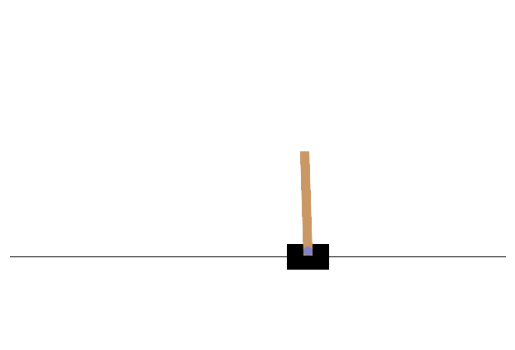

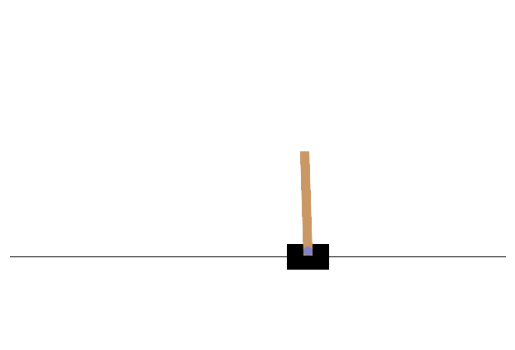

In [9]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

do_render = True

seed = 42
policy.set_random_seed(seed)

obs, info = digital_twin_env.reset(
    seed=seed, options={"physical_state": np.zeros(len(state_domain.var2values))}
)

for f in range(100):
    if do_render:
        frame = digital_twin_env.render()

        plt.imshow(frame)
        plt.axis("off")
        clear_output(wait=True)
        display(plt.gcf())

    action, _ = policy.predict(obs, deterministic=True)

    obs, reward, terminated, truncated, info = digital_twin_env.step(action)

    if terminated or truncated:
        print(f"simulation ended at frame {f}")
        break